# Import Packages

In [6]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import re
import emoji
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, normalize, LabelEncoder

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    confusion_matrix
)
from scipy.optimize import linear_sum_assignment

import umap

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
_analyzer = SentimentIntensityAnalyzer()

# Load Data

In [2]:
df_cleaned = pd.read_csv("cleaned_tweets.csv")
texts = df_cleaned["clean_text"].astype(str).tolist()

df_cleaned_sample = pd.read_csv("cleaned_sample_tweets.csv")

# Traditional Feature Extraction

In [11]:
# -------------------------------
# Helpers: features + metrics
# -------------------------------
def _count_emojis(s: str) -> int:
    return sum(ch in emoji.EMOJI_DATA for ch in s)

def _safe_ratio(num, den):
    den = den if den > 0 else 1
    return float(num) / float(den)

_DEFAULT_POS = {"good","great","amazing","love","loved","awesome","thanks","thank","best","upgrade","nice","happy"}
_DEFAULT_NEG = {"bad","worst","delay","delayed","late","hate","horrible","terrible","lost","cancel","canceled","cancellation","angry","sad"}

def extract_features(texts, version="v1", pos_lex=None, neg_lex=None):
    """
    v1 = ["word_count","avg_word_len","exclam_count","ques_count","upper_count","emoji_count","vader_compound"]
    v2 = v1 + ["exclam_ratio","ques_ratio","vader_pos","vader_neu","vader_neg","pos_lex_cnt","neg_lex_cnt","neg_pos_lex_ratio"]
    """
    if pos_lex is None: pos_lex = _DEFAULT_POS
    if neg_lex is None: neg_lex = _DEFAULT_NEG
    feats = []
    for s in texts:
        s = s if isinstance(s, str) else str(s)
        s_strip = s.strip()

        exclam_count = s_strip.count('!')
        ques_count   = s_strip.count('?')
        emoji_count  = _count_emojis(s_strip)

        tokens = s_strip.split()
        word_count = sum(1 for t in tokens if any(ch.isalpha() for ch in t))
        alpha_tokens = [''.join(ch for ch in t if ch.isalpha()) for t in tokens if any(ch.isalpha() for ch in t)]
        avg_word_len = (sum(len(t) for t in alpha_tokens) / len(alpha_tokens)) if alpha_tokens else 0.0
        upper_count  = sum(1 for t in tokens if t.isupper() and len(t) >= 2)

        vs = _analyzer.polarity_scores(s_strip)
        vader_pos, vader_neu, vader_neg, vader_compound = vs["pos"], vs["neu"], vs["neg"], vs["compound"]

        exclam_ratio = _safe_ratio(exclam_count, word_count)
        ques_ratio   = _safe_ratio(ques_count, word_count)

        lowered = [re.sub(r'^\W+|\W+$', '', t.lower()) for t in tokens]
        pos_lex_cnt = sum(1 for t in lowered if t in pos_lex)
        neg_lex_cnt = sum(1 for t in lowered if t in neg_lex)
        neg_pos_lex_ratio = _safe_ratio(neg_lex_cnt, pos_lex_cnt)

        row_v1 = [float(word_count), float(avg_word_len), float(exclam_count),
                  float(ques_count), float(upper_count), float(emoji_count), float(vader_compound)]

        if version == "v1":
            feats.append(row_v1)
        elif version == "v2":
            row_v2 = row_v1 + [float(exclam_ratio), float(ques_ratio),
                               float(vader_pos), float(vader_neu), float(vader_neg),
                               float(pos_lex_cnt), float(neg_lex_cnt), float(neg_pos_lex_ratio)]
            feats.append(row_v2)
        else:
            raise ValueError("version must be 'v1' or 'v2'")
    return np.asarray(feats, dtype=np.float32)

def clustering_accuracy(y_true_int, y_pred_int):
    cm = confusion_matrix(y_true_int, y_pred_int)
    r, c = linear_sum_assignment(-cm)
    return cm[r, c].sum() / cm.sum()

def evaluate_all(X, y_true_int, labels, sil_metric):
    sil = silhouette_score(X, labels, metric=sil_metric)
    ari = adjusted_rand_score(y_true_int, labels)
    nmi = normalized_mutual_info_score(y_true_int, labels)
    acc = clustering_accuracy(y_true_int, labels)
    return sil, ari, nmi, acc

# --------------------------------------
# Data + label encoding (stable mapping)
# --------------------------------------
texts_sample = df_cleaned_sample["clean_text"].astype(str).tolist()
texts_full   = df_cleaned["clean_text"].astype(str).tolist()

le = LabelEncoder()
le.fit(df_cleaned["airline_sentiment"].astype(str))
y_sample_enc = le.transform(df_cleaned_sample["airline_sentiment"].astype(str))
y_full_enc   = le.transform(df_cleaned["airline_sentiment"].astype(str))

# --------------------
# Configs 
# --------------------
feature_versions = ["v1", "v2"]
gmm_cov_types    = ["full", "tied", "diag", "spherical"]
agg_linkages     = ["average", "complete", "single"]

# results containers
df_tuning_rows = []   # subset (silhouette only)
df_best_rows   = []   # best per model per feature set
df_final_rows  = []   # full data with all metrics

# -------------
# Main routine 
# -------------
for version in feature_versions:
    print(f"\n=== Feature set: {version} (no DR) ===")

    # features
    Xs = extract_features(texts_sample, version=version)
    Xf = extract_features(texts_full,   version=version)

    # standardize and make cosine-friendly
    scaler_s = StandardScaler().fit(Xs)
    Xs_std   = scaler_s.transform(Xs).astype(np.float64)
    Xs_l2    = normalize(Xs_std, norm="l2")

    scaler_f = StandardScaler().fit(Xf)
    Xf_std   = scaler_f.transform(Xf).astype(np.float64)
    Xf_l2    = normalize(Xf_std, norm="l2")

    # ---------- KMEANS (fixed) ----------
    kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
    lab_s  = kmeans.fit_predict(Xs_l2)
    sil_s  = silhouette_score(Xs_l2, lab_s, metric="cosine")
    df_tuning_rows.append([version, "None", "KMeans", "-", sil_s])
    df_best_rows.append([version, "None", "KMeans", "-", sil_s])

    # ---------- GMM (tune covariance_type) ----------
    best_gmm = (None, -np.inf)
    for cov in gmm_cov_types:
        gmm   = GaussianMixture(n_components=3, n_init=10, random_state=42, covariance_type=cov)
        lab_s = gmm.fit_predict(Xs_std)  # euclidean after std
        sil_s = silhouette_score(Xs_std, lab_s, metric="euclidean")
        df_tuning_rows.append([version, "None", "GMM", cov, sil_s])
        if sil_s > best_gmm[1]:
            best_gmm = (cov, sil_s)
    df_best_rows.append([version, "None", "GMM", best_gmm[0], best_gmm[1]])

    # ---------- AGGLO (tune linkage; cosine) ----------
    def _agglo(metric_or_affinity, linkage, n_clusters=3):
        try:
            return AgglomerativeClustering(n_clusters=n_clusters, metric=metric_or_affinity, linkage=linkage)
        except TypeError:  # sklearn<1.2
            return AgglomerativeClustering(n_clusters=n_clusters, affinity=metric_or_affinity, linkage=linkage)

    best_agg = (None, -np.inf)
    for link in agg_linkages:
        agg   = _agglo("cosine", link, n_clusters=3)
        lab_s = agg.fit_predict(Xs_l2)
        sil_s = silhouette_score(Xs_l2, lab_s, metric="cosine")
        df_tuning_rows.append([version, "None", "Agglo", link, sil_s])
        if sil_s > best_agg[1]:
            best_agg = (link, sil_s)
    df_best_rows.append([version, "None", "Agglo", best_agg[0], best_agg[1]])

    # =========================
    # FINAL EVAL ON FULL DATA
    # =========================
    # KMeans
    kmeans_full = KMeans(n_clusters=3, n_init=10, random_state=42).fit(Xf_l2)
    lab_f = kmeans_full.labels_
    sil, ari, nmi, acc = evaluate_all(Xf_l2, y_full_enc, lab_f, sil_metric="cosine")
    df_final_rows.append([version, "None", "KMeans", "-", sil, ari, nmi, acc])

    # GMM
    gmm_full = GaussianMixture(n_components=3, n_init=10, random_state=42,
                               covariance_type=best_gmm[0]).fit(Xf_std)
    lab_f = gmm_full.predict(Xf_std)
    sil, ari, nmi, acc = evaluate_all(Xf_std, y_full_enc, lab_f, sil_metric="euclidean")
    df_final_rows.append([version, "None", "GMM", best_gmm[0], sil, ari, nmi, acc])

    # Agglo
    agg_full = _agglo("cosine", best_agg[0], n_clusters=3).fit(Xf_l2)
    lab_f = agg_full.labels_
    sil, ari, nmi, acc = evaluate_all(Xf_l2, y_full_enc, lab_f, sil_metric="cosine")
    df_final_rows.append([version, "None", "Agglo", best_agg[0], sil, ari, nmi, acc])

# ------------------------
# TABLES 
# ------------------------
df_tuning = pd.DataFrame(df_tuning_rows, columns=["Feature_Set","Reducer","Model","Param","Silhouette"])
df_best   = pd.DataFrame(df_best_rows,   columns=["Feature_Set","Reducer","Model","Best_Param","Best_Silhouette"])
df_final  = pd.DataFrame(df_final_rows,  columns=["Feature_Set","Reducer","Model","Param","Silhouette","ARI","NMI","Hungarian"])

print("\n================ Tuning (20% subset): all parameters & silhouette ================")
print(df_tuning.sort_values(["Feature_Set","Reducer","Model","Silhouette"], ascending=[True, True, True, False]).to_string(index=False))

print("\n================ Best Parameters per Branch (20% subset) ================")
print(df_best.sort_values(["Feature_Set","Reducer","Model"]).to_string(index=False))

print("\n================ Final Evaluation on Full Cleaned Data (All 6 best models) ================")
print(df_final.sort_values(["Feature_Set","Reducer","Model"]).to_string(index=False))

# ==========================================================
# Quick metric winners
# ==========================================================
for metric in ["Silhouette","ARI","NMI","Hungarian"]:
    r = df_final.loc[df_final[metric].idxmax()]
    print(f"\nWinner by {metric}: {r["Feature_Set"]}+{r["Model"]} | {metric}={r[metric]:.3f} | {r["Param"]}")


=== Feature set: v1 (no DR) ===

=== Feature set: v2 (no DR) ===

================ Tuning (20% subset): all parameters & silhouette ================
Feature_Set Reducer  Model     Param  Silhouette
         v1    None  Agglo   average    0.344664
         v1    None  Agglo  complete    0.344080
         v1    None  Agglo    single   -0.090795
         v1    None    GMM      diag    0.212222
         v1    None    GMM      full    0.195763
         v1    None    GMM      tied    0.191331
         v1    None    GMM spherical    0.156560
         v1    None KMeans         -    0.393412
         v2    None  Agglo   average    0.329216
         v2    None  Agglo  complete    0.308838
         v2    None  Agglo    single   -0.138342
         v2    None    GMM      tied    0.232809
         v2    None    GMM      diag    0.186877
         v2    None    GMM spherical    0.136919
         v2    None    GMM      full    0.119088
         v2    None KMeans         -    0.376471

================

# Visualisation

Running Traditional Feature Visualisation: v2 + KMeans (Hungarian winner)


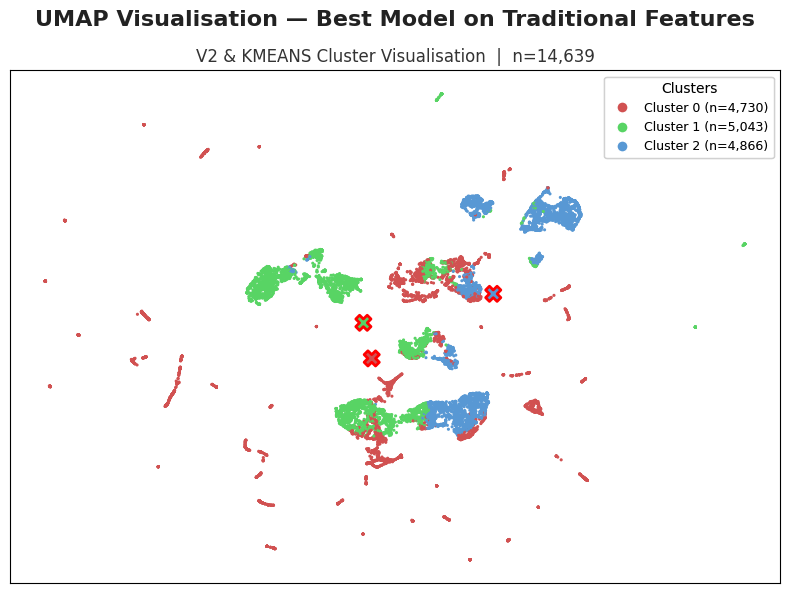

In [10]:
# ---------------------------
# CONFIG
# ---------------------------
RANDOM_STATE = 42
N_CLUSTERS   = 3
palette      = ["#d15151", "#58d464", "#5898d4"]  # red / green / blue

print("Running Traditional Feature Visualisation: v2 + KMeans (Hungarian winner)")

# -------------------------------
# Helpers: features
# -------------------------------
def _count_emojis(s: str) -> int:
    return sum(ch in emoji.EMOJI_DATA for ch in s)

def _safe_ratio(num, den):
    den = den if den > 0 else 1
    return float(num) / float(den)

_DEFAULT_POS = {"good","great","amazing","love","loved","awesome","thanks","thank","best","upgrade","nice","happy"}
_DEFAULT_NEG = {"bad","worst","delay","delayed","late","hate","horrible","terrible","lost","cancel","canceled","cancellation","angry","sad"}

def extract_features(texts, version="v1", pos_lex=None, neg_lex=None):
    """
    v1 = ["word_count","avg_word_len","exclam_count","ques_count","upper_count","emoji_count","vader_compound"]
    v2 = v1 + ["exclam_ratio","ques_ratio","vader_pos","vader_neu","vader_neg","pos_lex_cnt","neg_lex_cnt","neg_pos_lex_ratio"]
    """
    if pos_lex is None: pos_lex = _DEFAULT_POS
    if neg_lex is None: neg_lex = _DEFAULT_NEG
    feats = []
    for s in texts:
        s = s if isinstance(s, str) else str(s)
        s_strip = s.strip()

        exclam_count = s_strip.count('!')
        ques_count   = s_strip.count('?')
        emoji_count  = _count_emojis(s_strip)

        tokens = s_strip.split()
        word_count = sum(1 for t in tokens if any(ch.isalpha() for ch in t))
        alpha_tokens = [''.join(ch for ch in t if ch.isalpha()) for t in tokens if any(ch.isalpha() for ch in t)]
        avg_word_len = (sum(len(t) for t in alpha_tokens) / len(alpha_tokens)) if alpha_tokens else 0.0
        upper_count  = sum(1 for t in tokens if t.isupper() and len(t) >= 2)

        vs = _analyzer.polarity_scores(s_strip)
        vader_pos, vader_neu, vader_neg, vader_compound = vs["pos"], vs["neu"], vs["neg"], vs["compound"]

        exclam_ratio = _safe_ratio(exclam_count, word_count)
        ques_ratio   = _safe_ratio(ques_count, word_count)

        lowered = [re.sub(r'^\W+|\W+$', '', t.lower()) for t in tokens]
        pos_lex_cnt = sum(1 for t in lowered if t in pos_lex)
        neg_lex_cnt = sum(1 for t in lowered if t in neg_lex)
        neg_pos_lex_ratio = _safe_ratio(neg_lex_cnt, pos_lex_cnt)

        row_v1 = [float(word_count), float(avg_word_len), float(exclam_count),
                  float(ques_count), float(upper_count), float(emoji_count), float(vader_compound)]

        if version == "v1":
            feats.append(row_v1)
        elif version == "v2":
            row_v2 = row_v1 + [float(exclam_ratio), float(ques_ratio),
                               float(vader_pos), float(vader_neu), float(vader_neg),
                               float(pos_lex_cnt), float(neg_lex_cnt), float(neg_pos_lex_ratio)]
            feats.append(row_v2)
        else:
            raise ValueError("version must be 'v1' or 'v2'")
    return np.asarray(feats, dtype=np.float32)

# 1) Extract v2 features (same as training)
texts_full = df_cleaned["clean_text"].astype(str).tolist()
Xf = extract_features(texts_full, version="v2")

# 2) Standardize and L2-normalize (cosine-friendly)
scaler = StandardScaler().fit(Xf)
Xf_std = scaler.transform(Xf).astype(np.float64)
Xf_l2  = normalize(Xf_std, norm="l2")

# 3) Fit KMeans (3 clusters)
kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=10, random_state=RANDOM_STATE)
labels = kmeans.fit_predict(Xf_l2)

# 4) 2D UMAP for visualization (cosine to match space)
umap_2d = umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=2,
                    metric="cosine", random_state=RANDOM_STATE)
X_vis = umap_2d.fit_transform(Xf_l2)

# ---------------------------
# Plot 
# ---------------------------
fig, ax = plt.subplots(figsize=(8, 6))

# color by cluster using custom palette
colors = np.array(palette)[labels]
ax.scatter(X_vis[:, 0], X_vis[:, 1], c=colors, s=5, edgecolor="none")

# Legend with counts
unique, counts = np.unique(labels, return_counts=True)
size_map = dict(zip(unique, counts))
handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               label=f"Cluster {k} (n={size_map.get(k, 0):,})",
               markerfacecolor=palette[k], markersize=8)
    for k in range(N_CLUSTERS)
]
legend = ax.legend(handles=handles, title="Clusters", loc="best", fontsize=9)
ax.add_artist(legend)

# Centroids (in UMAP space)
centroids = np.vstack([X_vis[labels == k].mean(axis=0) for k in range(N_CLUSTERS)])
ax.scatter(centroids[:, 0], centroids[:, 1],
           s=120, marker="X", c=palette, edgecolor="red", linewidth=2.0, zorder=3)

# Titles 
ax.set_title("V2 & KMEANS Cluster Visualisation  |  n={:,}".format(len(labels)),
             fontsize=12, color="#333333")
plt.suptitle("UMAP Visualisation — Best Model on Traditional Features",
             fontsize=16, fontweight="bold", color="#222222")

plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()